## t-SNE

This notebook implements the t-SNE mapping for visualising higher dimensional datasets into lower dimensions.

In [1]:
# import libraries 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:

def reduceDimensionality(data, n_components = 30):
    """
    This function aims to reduce the higher dimensional data to lower dimensions [ = 30 ]
    """
    # standardize the data
    scaler = StandardScaler()
    x = data[:,:-1]
    y = data[:,-1]
    x = scaler.fit_transform(x)
    # apply PCA
    pca = PCA(n_components = n_components)
    x = pca.fit_transform(x)
    # concatenate the data
    data = np.concatenate((x, y.reshape(-1,1)), axis = 1)
    return data


In [3]:
def plotPCA(data,title):
    """
    Function to plot the generated PCA plot 
    """
    plt.figure(figsize=(10, 10))
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5,c=data[:,-1])
    plt.colorbar()
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title(title)
    plt.show()

## Load MNIST Dataset

- Loading the mnist dataset and reducing it to a lower dimensional space using PCA and number of components as 30

In [4]:
import seaborn as sns
from scipy.linalg import eigh

In [5]:
df = pd.read_csv('./data/mnist_train.csv')
print(df.shape)
df.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
labels = df['label']
data = df.drop('label', axis = 1)
data = data.values
data = np.concatenate((data, labels.values.reshape(-1,1)), axis = 1)
data = reduceDimensionality(data)
print(data.shape)
print(data[:5])


(42000, 31)
[[-5.14047762 -5.22644588  3.8870003  -0.90151177  4.92911477  2.03543249
   4.70692179 -4.76726295  0.23105936 -1.46058746  0.83097529  3.81055701
  -2.11205038 -4.31064716 -0.91293087  3.58845568  1.257711    1.34717845
  -0.3763329  -1.36376801 -2.20923349 -1.26791378 -1.38432311 -0.92679855
   2.37435203 -0.04751901  0.48101748 -2.16710756  1.25075147 -0.61311069
   1.        ]
 [19.29233219  6.0329965   1.30814763 -2.38329277  3.09516716 -1.79110205
  -3.7727863   0.15406448 -4.11465401 -4.29967433 -4.52702496 -0.70027272
  -1.0912182  -3.03392145  2.55484513  0.59672023 -3.14206179 -3.80623091
   0.05340556 -0.24922101 -2.38511905 -3.34254835 -0.14517089  0.15489213
  -0.60854371 -4.18470849 -0.1233581   0.13332139 -0.38276912 -2.14171571
   0.        ]
 [-7.64450336 -1.70581343  2.28932636  2.24113433  5.09442951 -4.15204494
  -1.01202422  1.73243736  0.4361877  -0.07374259 -0.70677396 -3.00730224
   0.86859878  3.17154508  2.22702668  0.35675895 -1.01812937 -0.51777

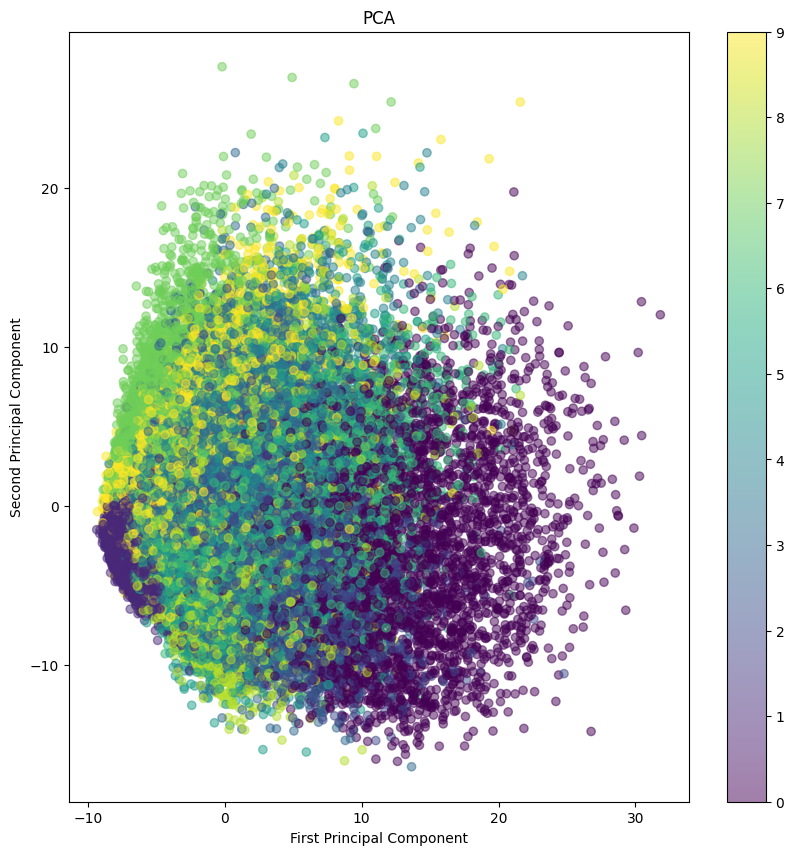

In [7]:
#  plot PCA
plotPCA(data, 'PCA')